In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    """Helper function for saving GIFs"""
    imgs = [Image.open(file) for file in files]
    imgs[0].save(
        fp=outfile, format='GIF', 
                 append_images=imgs[1:], save_all=True, 
                 duration=int(1000/fps), loop=loop
                 )

In [3]:
def gaussian_charge_density(x, y, Q, sigma, epsilon_0):
    """Defines a 2D Gaussian charge distribution"""
    r_squared = x**2 + y**2
    rho = (Q / (2 * np.pi * sigma**2)) * torch.exp(-r_squared / (2 * sigma**2))
    return rho / epsilon_0

In [4]:
def analytical_electric_field(x, y, Q, epsilon_0):
    """Analytical solution for electric field of a point charge"""
    r_squared = x**2 + y**2
    r = torch.sqrt(r_squared + 1e-8)  # small regularisation to avoid division by zero
    
    E_magnitude = Q / (4 * np.pi * epsilon_0 * r_squared)
    Ex = E_magnitude * x / r
    Ey = E_magnitude * y / r
    return Ex, Ey

In [5]:
class ElectricFieldNetwork(nn.Module):
    """Neural network to predict electric field components Ex and Ey"""
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [6]:
# Physical constants and parameters
Q = 1.0  # charge magnitude
epsilon_0 = 1.0  # permittivity (normalised)
sigma = 0.1  # width of Gaussian charge distribution
domain_size = 5.0

# Generate training data (boundary conditions)
# Create a circular boundary away from the charge
theta = torch.linspace(0, 2*np.pi, 32)
r_boundary = 10
x_boundary = r_boundary * torch.cos(theta).view(-1, 1)
y_boundary = r_boundary * torch.sin(theta).view(-1, 1)
xy_boundary = torch.cat([x_boundary, y_boundary], dim=1)

# Analytical solution at boundary
Ex_boundary, Ey_boundary = analytical_electric_field(x_boundary, y_boundary, Q, epsilon_0)
E_boundary = torch.cat([Ex_boundary, Ey_boundary], dim=1)

print(f"Boundary data shape: {xy_boundary.shape}, {E_boundary.shape}")

Boundary data shape: torch.Size([32, 2]), torch.Size([32, 2])


In [7]:
# Generate physics collocation points
n_physics = 500
x_physics = torch.rand(n_physics, 1) * domain_size - domain_size/2
y_physics = torch.rand(n_physics, 1) * domain_size - domain_size/2

# Remove points too close to the charge centre
distance_from_centre = torch.sqrt(x_physics**2 + y_physics**2)
mask = distance_from_centre > 0.05  # exclude region close to charge
x_physics = x_physics[mask.squeeze()]
y_physics = y_physics[mask.squeeze()]

xy_physics = torch.cat([x_physics, y_physics], dim=1).requires_grad_(True)

print(f"Physics collocation points: {xy_physics.shape}")

Physics collocation points: torch.Size([499, 2])


In [8]:
# Generate test grid for visualisation
x_test = torch.linspace(-1.5, 1.5, 101)
y_test = torch.linspace(-1.5, 1.5, 101)
X_test, Y_test = torch.meshgrid(x_test, y_test, indexing='ij')
xy_test = torch.stack([X_test.flatten(), Y_test.flatten()], dim=1)

In [9]:
def plot_electric_field(model, step):
    """Plot electric field vectors and magnitude"""
    model.eval()
    with torch.no_grad():
        E_pred = model(xy_test)
        Ex_pred = E_pred[:, 0].reshape(101, 101)
        Ey_pred = E_pred[:, 1].reshape(101, 101)
        
        # Calculate field magnitude
        E_magnitude = torch.sqrt(Ex_pred**2 + Ey_pred**2)
        
        # Convert to numpy for plotting
        X_np = X_test.numpy()
        Y_np = Y_test.numpy()
        Ex_np = Ex_pred.numpy()
        Ey_np = Ey_pred.numpy()
        E_mag_np = E_magnitude.numpy()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot field magnitude
        im1 = ax1.contourf(X_np, Y_np, E_mag_np, levels=21, cmap='viridis')
        ax1.set_title('Electric Field Magnitude')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        plt.colorbar(im1, ax=ax1)
        
        # Plot field vectors (subsample for clarity)
        skip = 3
        ax2.quiver(X_np[::skip, ::skip], Y_np[::skip, ::skip], 
                   Ex_np[::skip, ::skip], Ey_np[::skip, ::skip], 
                   E_mag_np[::skip, ::skip], cmap='viridis', scale=20)
        ax2.set_title('Electric Field Vectors')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_aspect('equal')
        
        # Mark charge location
        ax1.plot(0, 0, 'ro', markersize=8, label='Charge')
        ax2.plot(0, 0, 'ro', markersize=8, label='Charge')
        
        # Mark boundary points
        ax1.scatter(x_boundary.numpy(), y_boundary.numpy(), c='red', s=10, alpha=0.5, label='Boundary')
        ax2.scatter(x_boundary.numpy(), y_boundary.numpy(), c='red', s=10, alpha=0.5, label='Boundary')
        
        ax1.legend()
        ax2.legend()
        
        plt.suptitle(f'Training Step: {step}', fontsize=14)
        plt.tight_layout()
    
    model.train()

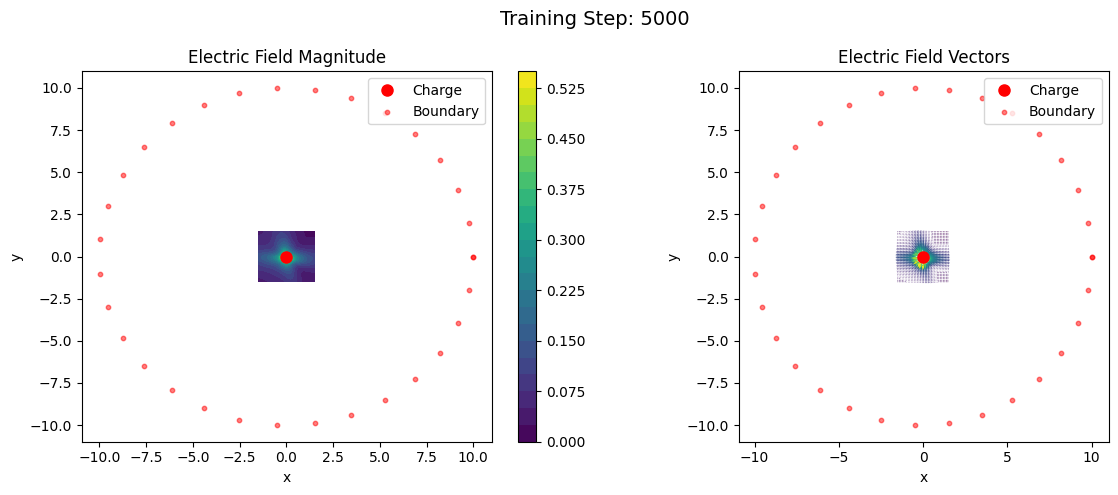

Step 5000: Boundary loss = 0.000008, Physics loss = 0.000011


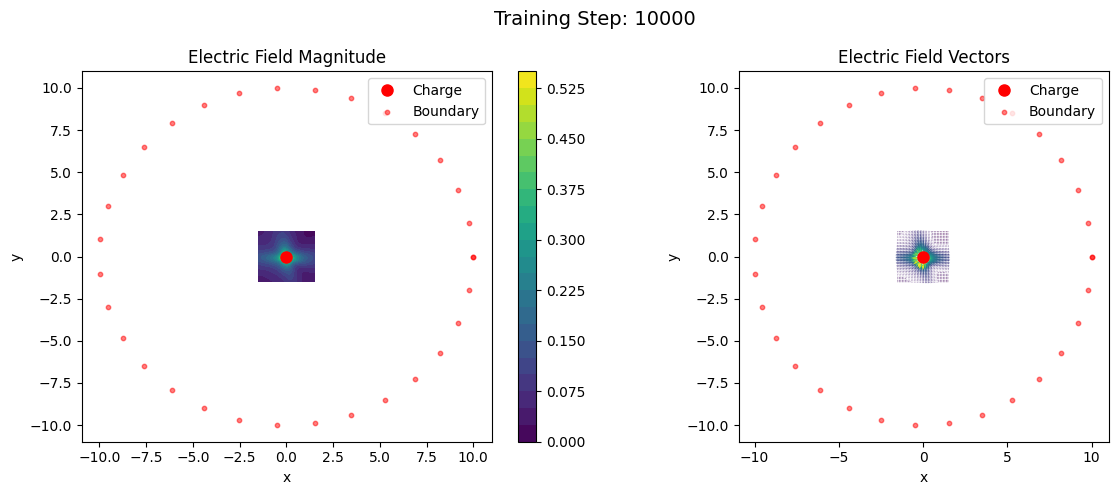

Step 10000: Boundary loss = 0.000000, Physics loss = 0.000003
Training completed!


In [10]:
# Initialise model
torch.manual_seed(123)
model = ElectricFieldNetwork(2, 2, 128, 4)  # 2 inputs (x,y), 2 outputs (Ex, Ey)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
files = []
for i in range(10000):
    optimizer.zero_grad()
    
    # Boundary condition loss
    E_pred_boundary = model(xy_boundary)
    loss_boundary = torch.mean((E_pred_boundary - E_boundary)**2)
    
    # Physics loss - Gauss's law: ∇·E = ρ/ε₀
    E_pred_physics = model(xy_physics)
    Ex_pred = E_pred_physics[:, 0:1]
    Ey_pred = E_pred_physics[:, 1:2]
    
    # Compute divergence using autograd
    dEx_dx = torch.autograd.grad(Ex_pred, xy_physics, torch.ones_like(Ex_pred), 
                                create_graph=True)[0][:, 0:1]
    dEy_dy = torch.autograd.grad(Ey_pred, xy_physics, torch.ones_like(Ey_pred), 
                                create_graph=True)[0][:, 1:2]
    
    divergence = dEx_dx + dEy_dy
    
    # Charge density at physics points
    x_phys = xy_physics[:, 0:1]
    y_phys = xy_physics[:, 1:2]
    rho_over_epsilon = gaussian_charge_density(x_phys, y_phys, Q, sigma, epsilon_0)
    
    # Physics loss
    physics_residual = divergence - rho_over_epsilon
    loss_physics = torch.mean(physics_residual**2)
    
    # Total loss
    loss = loss_boundary + 0.1 * loss_physics
    loss.backward()
    optimizer.step()
    
    # Plot progress
    if (i + 1) % 200 == 0:
        plot_electric_field(model, i + 1)
        
        file = f"electric_field_{i+1:06d}.png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i + 1) % 2500 == 0:
            plt.show()
            print(f"Step {i+1}: Boundary loss = {loss_boundary:.6f}, Physics loss = {loss_physics:.6f}")
        else:
            plt.close("all")

# Save animation
save_gif_PIL("electric_field_training.gif", files, fps=5, loop=0)

print("Training completed!")

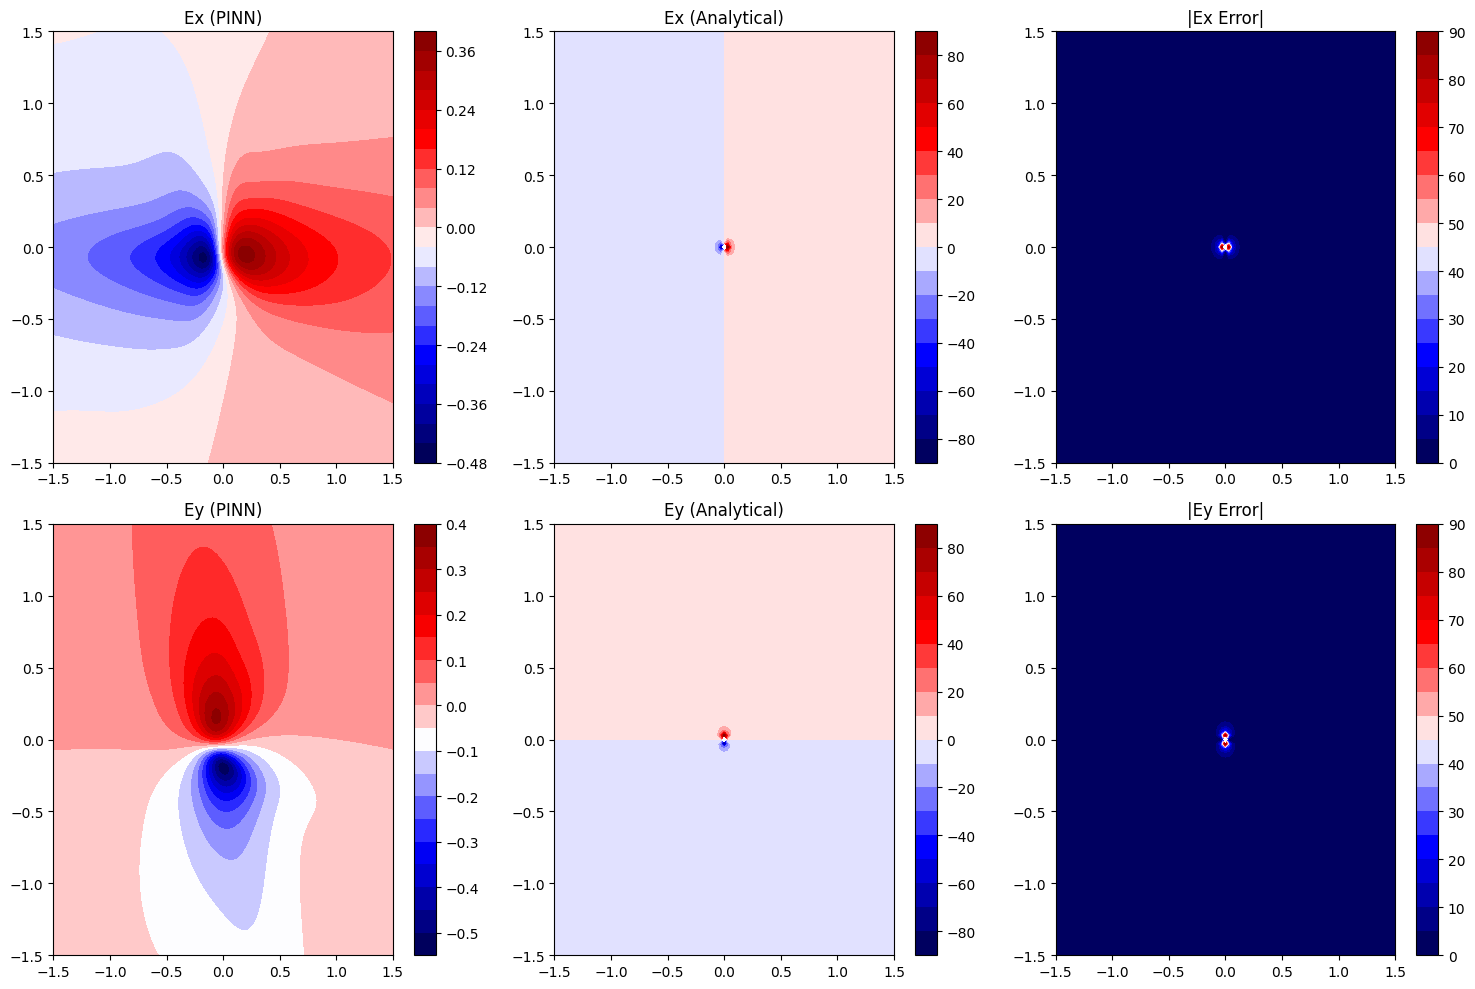

Mean absolute error - Ex: nan, Ey: nan


In [11]:
model.eval()
with torch.no_grad():
    E_pred = model(xy_test)
    Ex_pred = E_pred[:, 0].reshape(101, 101)
    Ey_pred = E_pred[:, 1].reshape(101, 101)
    
    # Analytical solution
    Ex_analytical, Ey_analytical = analytical_electric_field(
        X_test.flatten().view(-1, 1), Y_test.flatten().view(-1, 1), Q, epsilon_0
    )
    Ex_analytical = Ex_analytical.reshape(101, 101)
    Ey_analytical = Ey_analytical.reshape(101, 101)
    
    # Convert to numpy for plotting
    X_np = X_test.numpy()
    Y_np = Y_test.numpy()
    Ex_pred_np = Ex_pred.numpy()
    Ey_pred_np = Ey_pred.numpy()
    Ex_analytical_np = Ex_analytical.numpy()
    Ey_analytical_np = Ey_analytical.numpy()
    Ex_error_np = torch.abs(Ex_pred - Ex_analytical).numpy()
    Ey_error_np = torch.abs(Ey_pred - Ey_analytical).numpy()
    
    # Plot comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Ex component
    im1 = axes[0, 0].contourf(X_np, Y_np, Ex_pred_np, levels=21, cmap='seismic')
    axes[0, 0].set_title('Ex (PINN)')
    plt.colorbar(im1, ax=axes[0, 0])
    
    im2 = axes[0, 1].contourf(X_np, Y_np, Ex_analytical_np, levels=21, cmap='seismic')
    axes[0, 1].set_title('Ex (Analytical)')
    plt.colorbar(im2, ax=axes[0, 1])
    
    im3 = axes[0, 2].contourf(X_np, Y_np, Ex_error_np, levels=20, cmap='seismic')
    axes[0, 2].set_title('|Ex Error|')
    plt.colorbar(im3, ax=axes[0, 2])
    
    # Ey component
    im4 = axes[1, 0].contourf(X_np, Y_np, Ey_pred_np, levels=20, cmap='seismic')
    axes[1, 0].set_title('Ey (PINN)')
    plt.colorbar(im4, ax=axes[1, 0])
    
    im5 = axes[1, 1].contourf(X_np, Y_np, Ey_analytical_np, levels=20, cmap='seismic')
    axes[1, 1].set_title('Ey (Analytical)')
    plt.colorbar(im5, ax=axes[1, 1])
    
    im6 = axes[1, 2].contourf(X_np, Y_np, Ey_error_np, levels=20, cmap='seismic')
    axes[1, 2].set_title('|Ey Error|')
    plt.colorbar(im6, ax=axes[1, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Calculate error metrics
    ex_error = torch.mean(torch.abs(Ex_pred - Ex_analytical))
    ey_error = torch.mean(torch.abs(Ey_pred - Ey_analytical))
    print(f"Mean absolute error - Ex: {ex_error:.6f}, Ey: {ey_error:.6f}")